### Features to use for this
1. Player ID
2. Species (Protoss, Terran, Zerg)
3. APM (Actions Per Minute)
4. Count of "s" and "Base" /m
5. Count of hotkeys /m
5. Count of every hotkey uses

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')

In [24]:
# for dirname, _, filenames in os.walk('.\data'):
#     for filename in filenames:
#         filepath = os.path.join(dirname, filename)
#         print(filename)
#         largest_column_count = 0
#
#         with open(filepath, 'r') as temp_f:
#             # Read the lines
#             lines = temp_f.readlines()
#
#             for l in lines:
#                 # Count the column count for the current line
#                 column_count = len(l.split(',')) + 1
#
#                 # Set the new most column count
#                 largest_column_count = column_count if largest_column_count < column_count else largest_column_count
#
#         # Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
#         column_names = [i for i in range(0, largest_column_count)]
#
#         df = pd.read_csv(os.path.join(dirname, filename), header=None, names=column_names)


TEST.CSV
TRAIN.CSV


In [2]:
train_file = '../data/train.csv'

largest_column_count = 0

with open(train_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(',')) + 1

        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

column_names = [i for i in range(0, largest_column_count)]
data_df = pd.read_csv(train_file, header=None, names=column_names)

In [26]:
# # Find the longest match
# longest_length = 0
# for index, row in data_df.iterrows():
#     for i in range(2, len(row)):
#         if str(row[i]).startswith('t'):
#
#             longest_length = max(longest_length, int(row[i][1:]))
# print(longest_length)

KeyboardInterrupt: 

5770 seconds - which is 96 minutes. Therefore, we will collect stats for only the first 25 minutes of the game. Also, we will only collect stats for **whole minutes**. For example, if a match is 7:25 long, we will only collect stats for the first 7 minutes.

In [ ]:
# OLD CODE
list_of_dicts = []
species = {'Protoss': 0, 'Terran': 1, 'Zerg': 2}
player_id_dict = {}
max_time = 25
for index, row in data_df.iterrows():
    # Creates a dictionary of features for each player
    buffer_dict = {}

    # Grab the player's ID number from the first column. It looks like this, for example: http://eu.battle.net/sc2/en/profile/3538115/1/Golden/
    # We want to grab the 3538115 part
    player_id = str(row[0]).split('/')[6]
    if player_id not in player_id_dict:
        player_id_dict[player_id] = len(player_id_dict)

    buffer_dict['player_id'] = player_id_dict[player_id]

    # Player's species (Protoss, Terran, Zerg) - 0, 1, 2
    buffer_dict['species'] = species[str(row[1])]

    # Player's APM calculation
    apm = 0
    keystrokes = 0

    # Count of button presses per minute for the first 30 minutes
    # buffer_dict['s_1'] corresponds to the number of "s" presses from 0:00 to 1:00

    game_time_second = 0
    game_time_minute = 0
    number_of_s = 0 #s
    number_of_base = 0 #Base
    number_of_sm = 0 #SingleMineral
    long_game = False
    for i in range(2, len(row)):
        if pd.isnull(row[i]):
            break
        if str(row[i]).startswith('t'):
            game_time_second += 5
            if game_time_second % 60 == 0:

                game_time_minute += 1

                buffer_dict['s_' + str(game_time_minute)] = number_of_s
                buffer_dict['base_' + str(game_time_minute)] = number_of_base
                buffer_dict['sm_' + str(game_time_minute)] = number_of_sm
                number_of_s = 0
                number_of_base = 0
                number_of_sm = 0

                if game_time_minute == max_time:
                    break
        else:
            action = str(row[i])
            keystrokes += 1
            if action == 's':
                number_of_s += 1
            elif action == 'Base':
                number_of_base += 1
            elif action == 'SingleMineral':
                number_of_sm += 1
    if game_time_minute < max_time:
        for i in range(game_time_minute+1, max_time+1):
            buffer_dict['s_' + str(i)] = -1
            buffer_dict['base_' + str(i)] = -1
            buffer_dict['sm_' + str(i)] = -1
    # APM
    #print("*** INDEX: " + str(index) + " ***")
    #print(buffer_dict)
    # We disregard games last less than a minute.
    if game_time_minute == 0:
        continue
    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk'+str(i)] = 0
        for j in range(3):
            mask = row == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])
    # Count the number of every hotkeys used
    buffer_dict['apm'] = keystrokes / game_time_minute
    list_of_dicts.append(buffer_dict)
# END OF OLD CODE

In [17]:
## NEW CODE
list_of_dicts = []
species = {'Protoss': 0, 'Terran': 1, 'Zerg': 2}
max_time = 25
for index, row in data_df.iterrows():
    # Creates a dictionary of features for each player
    buffer_dict = {}

    buffer_dict['player_id'] = row[0]

    # Player's species (Protoss, Terran, Zerg) - 0, 1, 2
    buffer_dict['species'] = species[str(row[1])]

    first_20s_index = row.str.find('t20').idxmax()
    first_20s = row[:first_20s_index]

    #find first index of value start with hotkey
    

    # Count each selection of the player during the first 20s
    buffer_dict['s_20s'] = len(first_20s[first_20s == 's'])
    buffer_dict['base_20s'] = len(first_20s[first_20s == 'Base'])
    buffer_dict['sm_20s'] = len(first_20s[first_20s == 'SingleMineral'])
    #buffer_dict['hotkey_20s'] = len(first_20s[first_20s.str.startswith('hotkey')])

    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk_20s'+str(i)] = 0
        for j in range(3):
            mask = first_20s == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])
    
    # Player's APM calculation
    apm = 0

    # Count each selection of the player during the match
    buffer_dict['s'] = len(row[row == 's'])
    buffer_dict['base'] = len(row[row == 'Base'])
    buffer_dict['sm'] = len(row[row == 'SingleMineral'])

    # Disregard games with no timestamps
    if row.str.startswith('t').sum == 0:
        continue
    buffer_dict['game_time'] = row.str.startswith('t').sum() * 5 // 60
    keystrokes = row.count() - 2 - row.str.startswith('t').sum()
    # APM
    #print("*** INDEX: " + str(index) + " ***")
    #print(buffer_dict)
    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk'+str(i)] = 0
        for j in range(3):
            mask = row == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])
    if buffer_dict['game_time'] == 0:
        buffer_dict['apm'] = keystrokes
    else:
        buffer_dict['apm'] = keystrokes / buffer_dict['game_time']
    list_of_dicts.append(buffer_dict)

In [18]:
# Create a dataframe from the list of dictionaries
df = pd.DataFrame.from_records(list_of_dicts)
print(df)

                                              player_id  species  s_20s  \
0     http://eu.battle.net/sc2/en/profile/4234852/1/...        0      6   
1     http://eu.battle.net/sc2/en/profile/3074362/1/...        0     19   
2     http://eu.battle.net/sc2/en/profile/4234852/1/...        0      8   
3     http://eu.battle.net/sc2/en/profile/3074362/1/...        0     12   
4     http://eu.battle.net/sc2/en/profile/4234852/1/...        0      7   
...                                                 ...      ...    ...   
3047     http://xx.battle.net/sc2/en/profile/405/1/MMA/        1     22   
3048  http://xx.battle.net/sc2/en/profile/410/1/STBo...        1     34   
3049     http://xx.battle.net/sc2/en/profile/405/1/MMA/        1     19   
3050  http://xx.battle.net/sc2/en/profile/410/1/STBo...        1     28   
3051     http://xx.battle.net/sc2/en/profile/405/1/MMA/        1     16   

      base_20s  sm_20s  hotkey_20s    s  base  sm  game_time  ...  hk1  hk2  \
0            2      

In [19]:
# Seperate data into features and target
X = df.drop(['player_id'], axis=1)
y = df['player_id']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
#check Nan in data
check_nan = df.isnull().values

#count the number of NaN in each column
nb_nan = df.isnull().sum()
 
# printing the result
print(nb_nan)

player_id     0
species       0
s_20s         0
base_20s      0
sm_20s        0
hotkey_20s    0
s             0
base          0
sm            0
game_time     0
hk0           0
hk1           0
hk2           0
hk3           0
hk4           0
hk5           0
hk6           0
hk7           0
hk8           0
hk9           0
apm           0
dtype: int64


In [21]:
# Create a random forest classifier
model = RandomForestClassifier(random_state=2)
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Calcul de l'erreur de prédiction
accuracy = model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1:', f1)
print('Accuracy:', accuracy)

F1: 0.7584448922549609
Accuracy: 0.8657937806873978


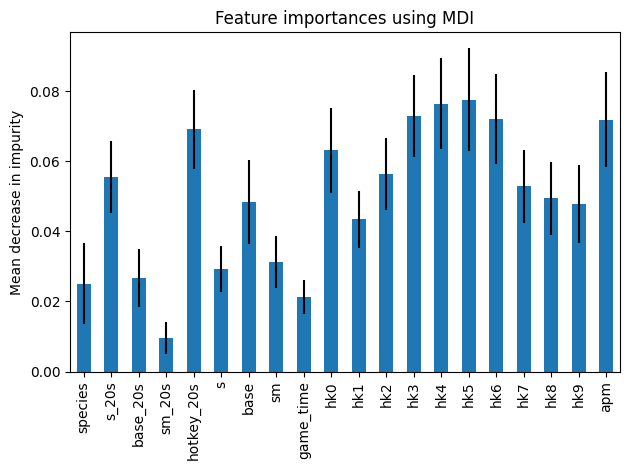

In [22]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [38]:
### TEST ###
test_file = './data/TEST.CSV'

largest_column_count = 0

with open(train_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(',')) + 1

        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

column_names = [i for i in range(0, largest_column_count)]
test_df = pd.read_csv(test_file, header=None, names=column_names)

In [41]:
### TEST
test_dicts = []
species = {'Protoss': 0, 'Terran': 1, 'Zerg': 2}
max_time = 25
for index, row in test_df.iterrows():
    # Creates a dictionary of features for each player
    # Player's species (Protoss, Terran, Zerg) - 0, 1, 2
    buffer_dict = {'species': species[str(row[0])]}

    # Player's APM calculation
    apm = 0

    # Count of button presses per minute for the first 30 minutes
    # buffer_dict['s_1'] corresponds to the number of "s" presses from 0:00 to 1:00
    buffer_dict['s'] = len(row[row == 's'])
    buffer_dict['base'] = len(row[row == 'Base'])
    buffer_dict['sm'] = len(row[row == 'SingleMineral'])
    buffer_dict['game_time'] = row.str.startswith('t').sum() * 5 // 60
    keystrokes = row.count() - 1 - row.str.startswith('t').sum()

    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk'+str(i)] = 0
        for j in range(3):
            mask = row == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])

    # APM

    if buffer_dict['game_time'] == 0:
        buffer_dict['apm'] = keystrokes
    else:
        buffer_dict['apm'] = keystrokes / buffer_dict['game_time']
    test_dicts.append(buffer_dict)

In [43]:
prediction = model.predict(pd.DataFrame.from_records(test_dicts))
print(len(prediction))
submission_dict = {'RowId': [], 'prediction': []}
for i in range(len(prediction)):
    submission_dict['RowId'].append(i+1)
    submission_dict['prediction'].append(prediction[i])
submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv('submission.csv', index=False)
# with open('submission.csv', 'w', encoding="utf-8") as csvfile:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow(fields)
#     csvwriter.writerows(rows)

340


In [123]:
# Create a decision tree classifier
model = DecisionTreeClassifier(random_state=1, criterion='entropy')
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Calcul de l'erreur de prédiction
acc = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
print('Accuracy:', acc)
print('MSE:', mse)
print('MAE:', mae)

Accuracy: 0.7182866556836903
MSE: 1659.68039538715
MAE: 17.647446457990114


In [124]:
# Create a neural network classifier
model = MLPClassifier(random_state=1)
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Calcul de l'erreur de prédiction
acc = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)

Accuracy: 0.7215815485996705
MSE: 1831.6079077429983
MAE: 19.044481054365733
